test: apply lda onto a small corpus

--- 

In [31]:
import pandas as pd
from tm_preprocessor import Preprocessor

In [67]:
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
from sqlalchemy import create_engine
engine = create_engine('postgresql://zhiyzuo@localhost:5432/ic2s2_datathon')

---

#### preprocessing

In [9]:
text_df = pd.read_sql_table(table_name='text', con=engine)
text_df.head(2)

,qa_id,text,asker_id,answerer_id,type,post_user_id,disease
0,0,"Hello, I'm a male in his 20s and I've had fati...",TigerShot,"Faye Lang, RN, MSW",q,TigerShot,psychiatric topics
1,1,Hello.. You might remember me contacting you 3...,marcia smith,"Faye Lang, RN, MSW",q,marcia smith,psychiatric topics


In [10]:
text_df.tail(2)

,qa_id,text,asker_id,answerer_id,type,post_user_id,disease
22001,79,"Dear CED, I havent heard anything to indicate ...",CED,Dr. Tamer Fouad,a,Dr. Tamer Fouad,leukemia
22002,80,"Dear Janet, Leukemia is an aggressive disease ...",JANET B,Dr. Tamer Fouad,a,Dr. Tamer Fouad,leukemia


setup an index so that there's a unique id

In [11]:
text_df['index'] = pd.np.arange(text_df.shape[0])
text_df.head(2)

,qa_id,text,asker_id,answerer_id,type,post_user_id,disease,index
0,0,"Hello, I'm a male in his 20s and I've had fati...",TigerShot,"Faye Lang, RN, MSW",q,TigerShot,psychiatric topics,0
1,1,Hello.. You might remember me contacting you 3...,marcia smith,"Faye Lang, RN, MSW",q,marcia smith,psychiatric topics,1


subset

In [12]:
df = text_df[['index', 'text', 'type', 'disease', 'post_user_id']]
df.head(2)

,index,text,type,disease,post_user_id
0,0,"Hello, I'm a male in his 20s and I've had fati...",q,psychiatric topics,TigerShot
1,1,Hello.. You might remember me contacting you 3...,q,psychiatric topics,marcia smith


In [13]:
df.shape

(22003, 5)

In [16]:
doc_arr = df.text.values.tolist()
doc_arr[-1]

'Dear Janet, Leukemia is an aggressive disease of the blood cells. The blood cells turn into cancer cells. This requires aggressive treatment in the form of chemotherapy and sometimes various bone marrow transplantation techniques.  Spontaneous bleeding denotes a bleeding tendency which may be due to the disease itself or due to the chemo or a manifestation of an associated condition.  Vomiting is a known side effect of chemotherapy however there are many other causes (check the symptom diagnosis list in the left hand menu of this page).  What type of leukemia was she diagnosed with? What is her last CBC count? how many days has she been on chemo?  Best regards,'

In [17]:
preprocessor = Preprocessor(doc_arr)

In [18]:
preprocessor.remove_digits_punctuactions()

In [19]:
preprocessor.remove_stopwords()

In [27]:
min_freq = 0
max_freq = 1
min_len = 2

In [30]:
import nltk
lemmatizer  = nltk.WordNetLemmatizer()
#stemmer  = nltk.PorterStemmer()

In [31]:
preprocessor.normalize(lemmatizer, min_freq, max_freq, min_len)
#preprocessor.normalize(stemmer, min_freq, max_freq, min_len)

export

In [33]:
preprocessor.serialize(format_='MmCorpus', path='./data/')

dictionary

In [39]:
dictionary = corpora.Dictionary(preprocessor.corpus)

In [40]:
dictionary.save('data/corpus.dict')

---

#### apply lda

In [15]:
from gensim import corpora
from gensim.models import ldamodel, ldamulticore
from gensim.models.coherencemodel import CoherenceModel

In [5]:
corpus = corpora.MmCorpus('data/corpus_MmCorpus.dump')
corpus.num_docs

22003

In [9]:
dictionary = corpora.Dictionary.load('data/corpus.dict')

to vector

##### test

In [24]:
param_dict = {'num_topics': 50, 'workers': 25,
              'chunksize': len(corpus)//3, 'passes': 5}

In [25]:
lda = ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                **param_dict)

In [27]:
cm = CoherenceModel(model=lda, corpus=corpus,
                    coherence='u_mass')
cm.get_coherence()

-2.0316351759805338

##### run for different `num_topics`

In [29]:
result_list = list()
for k in range(100, 151, 10):
    param_dict = {'num_topics': k, 
                  'workers': 25,
                  'chunksize': len(corpus)//3, 
                  'passes': 5}
    
    lda = ldamulticore.LdaMulticore(corpus=corpus, 
                                    id2word=dictionary, 
                                    **param_dict)
    cm = CoherenceModel(model=lda, corpus=corpus,
                        coherence='u_mass')
    score = cm.get_coherence()
    result_list.append({'num_topics': k, 'coherence': score})

/Users/zhiyzuo/.virtualenvs/Zuo-Py3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [32]:
pd.DataFrame(result_list)

,coherence,num_topics
0,-2.158152,100
1,-2.163577,110
2,-2.174580,120
3,-2.139994,130
4,-2.152813,140
5,-2.170055,150


In [33]:
result_df = pd.DataFrame(result_list)
result_df.to_csv('data/topic_coherence.csv', index=False)

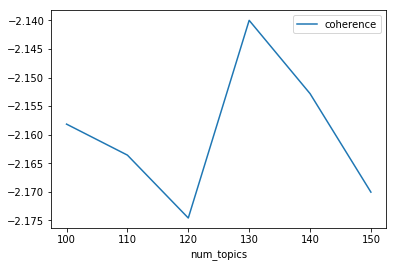

In [69]:
result_df.plot(x='num_topics', y='coherence', kind='line')

---

#### best lda model

k = 130

In [35]:
param_dict = {'num_topics': 130, 'workers': 28,
              'chunksize': len(corpus)//3, 'passes': 5}

In [36]:
lda = ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary, 
                                **param_dict)

/Users/zhiyzuo/.virtualenvs/Zuo-Py3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


save model

In [64]:
model_path = "./data/ldamodel"

In [65]:
lda.save(model_path)

topic representation

In [66]:
for i, topic_str in lda.show_topics(num_topics=10, num_words=10):
    print('topic', i)
    print(topic_str)

topic 33
0.012*"symptom" + 0.010*"disease" + 0.010*"problem" + 0.009*"pain" + 0.008*"test" + 0.008*"doctor" + 0.007*"thyroid" + 0.007*"blood" + 0.007*"good" + 0.007*"find"
topic 102
0.010*"heart" + 0.009*"rate" + 0.007*"case" + 0.006*"problem" + 0.006*"infection" + 0.006*"doctor" + 0.005*"time" + 0.005*"long" + 0.005*"pain" + 0.005*"common"
topic 56
0.027*"day" + 0.017*"pain" + 0.009*"test" + 0.008*"normal" + 0.007*"month" + 0.007*"doctor" + 0.007*"time" + 0.006*"leave" + 0.005*"problem" + 0.005*"year"
topic 118
0.010*"time" + 0.009*"normal" + 0.009*"week" + 0.008*"test" + 0.008*"year" + 0.007*"month" + 0.006*"nipple" + 0.006*"period" + 0.005*"pregnancy" + 0.005*"doctor"
topic 5
0.020*"abilify" + 0.011*"buy" + 0.008*"bump" + 0.007*"skin" + 0.007*"doctor" + 0.006*"symptom" + 0.006*"disorder" + 0.006*"start" + 0.006*"time" + 0.006*"month"
topic 39
0.021*"day" + 0.020*"year" + 0.014*"blood" + 0.014*"week" + 0.014*"time" + 0.009*"mg" + 0.009*"month" + 0.007*"normal" + 0.007*"ve" + 0.006*"p

---

#### calculate topical diversity

In [70]:
corpus

In [79]:
doc_topic_dist = lda.get_document_topics(bow=corpus, minimum_probability=0)
type(doc_topic_dist)

gensim.interfaces.TransformedCorpus

##### test

does topic distribution sum to 1?

In [80]:
doc_topic_dist[0]

[(0, 5.2687039e-05),
 (1, 5.2687039e-05),
 (2, 5.2687039e-05),
 (3, 5.2687039e-05),
 (4, 5.2687039e-05),
 (5, 5.2687039e-05),
 (6, 5.2687039e-05),
 (7, 5.2687039e-05),
 (8, 5.2687039e-05),
 (9, 5.2687039e-05),
 (10, 5.2687039e-05),
 (11, 5.2687039e-05),
 (12, 0.096448436),
 (13, 5.2687039e-05),
 (14, 5.2687039e-05),
 (15, 5.2687039e-05),
 (16, 5.2687039e-05),
 (17, 5.2687039e-05),
 (18, 5.2687039e-05),
 (19, 5.2687039e-05),
 (20, 5.2687039e-05),
 (21, 5.2687039e-05),
 (22, 5.2687039e-05),
 (23, 5.2687039e-05),
 (24, 5.2687039e-05),
 (25, 0.092528366),
 (26, 0.23910363),
 (27, 5.2687039e-05),
 (28, 5.2687039e-05),
 (29, 5.2687039e-05),
 (30, 5.2687039e-05),
 (31, 5.2687039e-05),
 (32, 5.2687039e-05),
 (33, 5.2687039e-05),
 (34, 5.2687039e-05),
 (35, 5.2687039e-05),
 (36, 5.2687039e-05),
 (37, 5.2687039e-05),
 (38, 5.2687039e-05),
 (39, 5.2687039e-05),
 (40, 5.2687039e-05),
 (41, 5.2687039e-05),
 (42, 5.2687039e-05),
 (43, 5.2687039e-05),
 (44, 5.2687039e-05),
 (45, 5.2687039e-05),
 (46,

In [82]:
sum([p for _, p in doc_topic_dist[0]])

0.99999997640770744

In [85]:
topic_dist_df = pd.DataFrame(doc_topic_dist[0], columns=['topic', 'probability'])
topic_dist_df.head(2)

,topic,probability
0,0,0.000053
1,1,0.000053


##### convert to df first

In [86]:
len(doc_topic_dist)

22003

In [88]:
doc_topic_df = list()
for i in range(len(doc_topic_dist)):
    tmp_df = pd.DataFrame(doc_topic_dist[i],
                          columns=['topic', 'probability'])
    tmp_df['doc_index'] = i
    doc_topic_df.append(tmp_df)
doc_topic_df = pd.concat(doc_topic_df, ignore_index=True)
doc_topic_df.head(2)

,topic,probability,doc_index
0,0,0.000053,0
1,1,0.000053,0


reshape dataframe

In [91]:
wide_dt_df = doc_topic_df.pivot_table(index='doc_index', columns=['topic'], values='probability')
wide_dt_df.head(2)

topic,0,1,2,3,4,5,6,7,8,9,...,120,121,122,123,124,125,126,127,128,129
doc_index,,,,,,,,,,,,,,,,,,,,,
0,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,...,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053,0.000053
1,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,...,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063,0.000063


In [93]:
wide_dt_df.to_csv('./data/doc-topic-df.csv')

##### entropy: diversity

In [97]:
import scipy as sp
from joblib import Parallel, delayed

In [94]:
wide_dt_df.loc[0].values

array([  5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         9.94876623e-02,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   8.70015696e-02,   2.39781991e-01,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,   5.26870463e-05,   5.26870463e-05,
         5.26870463e-05,

In [95]:
sp.stats.entropy(wide_dt_df.loc[0].values)

1.5616583272854041

In [102]:
def calc_topic_diversity(i, val):
    return i, sp.stats.entropy(val)

In [103]:
i = 3
calc_topic_diversity(i, wide_dt_df.loc[i].values)

(3, 0.97344700189040922)

In [104]:
n_jobs = 25

In [105]:
doc_topic_diversity_df = Parallel(n_jobs=n_jobs)(delayed(calc_topic_diversity)(i, val.values) for i, val in wide_dt_df.iterrows())
doc_topic_diversity_df = pd.DataFrame(doc_topic_diversity_df, columns=['doc_index', 'topic_diversity'])

In [106]:
doc_topic_diversity_df.head(2)

,doc_index,topic_diversity
0,0,1.561658
1,1,0.086766


---

##### merge with sentiment

In [107]:
sentiment_df = pd.read_csv('data/sentiment.csv')
sentiment_df.head(2)

,index,text,type,disease,user_id,compound,neg,neu,pos,age,gender,role,role_binary
0,0,"Hello, I'm a male in his 20s and I've had fati...",q,psychiatric topics,TigerShot,-0.6515,0.123,0.776,0.101,32.0,0,patient,1
1,2207,I'm a 23 year old male and my problems started...,q,neurology topics,TigerShot,-0.9760,0.145,0.793,0.062,32.0,0,patient,1


In [109]:
sentiment_df.shape[0], doc_topic_diversity_df.shape[0]

(22003, 22003)

In [111]:
sentiment_df['topic_diversity'] = doc_topic_diversity_df.topic_diversity.values

In [114]:
sentiment_df.head(2)

,index,text,type,disease,user_id,compound,neg,neu,pos,age,gender,role,role_binary,topic_diversity
0,0,"Hello, I'm a male in his 20s and I've had fati...",q,psychiatric topics,TigerShot,-0.6515,0.123,0.776,0.101,32.0,0,patient,1,1.561658
1,2207,I'm a 23 year old male and my problems started...,q,neurology topics,TigerShot,-0.9760,0.145,0.793,0.062,32.0,0,patient,1,0.086766


In [116]:
sentiment_df.to_csv('data/sentiment-topic_diversity.csv', index=False)

In [117]:
sentiment_df.drop(columns=['text', 'user_id']).to_stata('data/sentiment-topic_diversity.dta')